In [17]:
import os
from dotenv import load_dotenv
from pyathena import connect
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

load_dotenv()

try:
    conn = connect(
        aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
        aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY'),
        s3_staging_dir='s3://halight-athena-query-results/stclair/',
        region_name='us-east-1',
        schema_name='s3_atmos_stclair',
        catalog_name='AwsDataCatalog'
    )
    
    cursor = conn.cursor()
    cursor.execute("SHOW TABLES IN s3_atmos_stclair")
    tables = cursor.fetchall()
    
    print(f"Found {len(tables)} tables:")
    for table in tables:
        print(f"- {table[0]}")
        
except Exception as e:
    print(f"Error: {e}")

Found 32 tables:
- achievement_user_completions
- achievements
- banner_clicks
- bdg_user_completions
- certification_users
- comment_likes
- community_comments
- country_states
- instances
- instances_v
- li_attempts
- li_stats_agg_all
- li_stats_agg_all_v
- mi_user_mission_step_completions
- offboarded_instances
- poll_user_completions
- rank_user_completions
- rcs_historic_users
- rcs_historic_users_v
- rcs_lifetime_stats_by_month_v
- rcs_user_lifetimes_no_stats_v
- reward_prizes
- reward_user_claims
- reward_user_claims_v
- rewards
- sale_user_submissions
- snippet_view_logs
- snippets
- survey_user_completions
- test2_v
- test_v
- users


In [18]:
# 1. USER ENGAGEMENT & ADOPTION
users = pd.read_sql_query("SELECT * FROM users LIMIT 100000", conn)
print("User engagement loaded")


User engagement loaded


In [19]:
users.shape

(100000, 82)

**Dataset Overview:**
- **100,000 rows** × **82 columns** in the users table
- *Note: Data was limited to 100,000 rows during extraction for analysis purposes*
- This represents a sample of the full Halight user database for efficient analysis

In [20]:
users.dtypes.value_counts()

object            45
datetime64[ns]    15
int64             12
float64           10
Name: count, dtype: int64

**Data Types Distribution:**
- **45 Object columns**     (user_id, account_status, country_name, retailer, user_type, etc.)
- **15 Datetime columns**   (account_created_ts, last_login_ts, last_online_ts, first_li_completion_ts, etc.)
- **12 Integer columns**    (total_points_earned, points_balance, num_li_completions, user_rank_number, etc.)
- **10 Float columns**      (location_latitude, location_longitude, and other measurement data)

*This shows a rich dataset with user profiles, engagement metrics, and temporal activity data.*

In [41]:
# Show null counts and percentages for columns with missing data
null_counts = users.isnull().sum()
null_pct = (users.isnull().sum() / len(users)) * 100

pd.DataFrame({
    'Null_Count': null_counts[null_counts > 0],
    'Null_Percentage': null_pct[null_counts > 0]
}).sort_values('Null_Count', ascending=False)

,Null_Count,Null_Percentage
account_merged_ts,99251,99.251
custom_field,98859,98.859
admin_auto_access_id,98405,98.405
report_auto_access_id,98405,98.405
report_access_title,98405,98.405
...,...,...
hierarchy_title,10714,10.714
is_opted_in_for_marketing_coms,5022,5.022
country_name,985,0.985
user_type,22,0.022


**Null Values Summary:**
- **63 columns have missing data** (77% of all columns)
- **19 columns have no nulls** (23% of all columns)
- **Critical finding:** Many columns have >90% null values
- **Key columns** like account_created_ts, user_id are nearly complete

In [42]:
# Show columns with NO null values
no_nulls = users.isnull().sum() == 0
print("Columns with NO null values:")
users.columns[no_nulls].tolist()

Columns with NO null values:


['instance_id',
 'generated_for_date',
 'generated_ts',
 'user_id',
 'account_status',
 'verification_status',
 'is_self_registration',
 'is_quick_referral',
 'timezone',
 'can_display_user_info',
 'total_points_earned',
 'total_points_spent',
 'points_balance',
 'num_li_completions',
 'num_unique_li_completions',
 'num_achievements',
 'num_badges',
 'num_user_referrals',
 'num_connections']

In [43]:
# Count and list categorical columns
cat_cols = users.select_dtypes(include='object').columns
print(f"Categorical columns: {len(cat_cols)}")
print(cat_cols.tolist())

# Count and list numerical columns  
num_cols = users.select_dtypes(include='number').columns
print(f"\n Numerical columns: {len(num_cols)}")
print(num_cols.tolist())

Categorical columns: 45
['instance_id', 'generated_for_date', 'user_id', 'employee_number', 'account_status', 'verification_status', 'user_type_id', 'user_type', 'hierarchy_title', 'retailer_id', 'retailer', 'location_country_code', 'location_state', 'location_id', 'location_title', 'location_code', 'location_longitude', 'location_latitude', 'location_city', 'location_zipcode', 'location_address_line1', 'location_address_line2', 'location_metadata_json', 'country_code', 'country_name', 'user_rank_id', 'user_rank_title', 'first_verification_method', 'referred_by_referral_code', 'referred_by_user_id', 'referred_by_first_name', 'referred_by_last_name', 'referred_by_user_type_title', 'referred_by_retailer_title', 'referred_by_location_title', 'timezone', 'preferred_language_id', 'custom_field', 'origin_auth_source_id', 'admin_access_id', 'admin_access_title', 'admin_auto_access_id', 'report_access_id', 'report_access_title', 'report_auto_access_id']

 Numerical columns: 22
['user_rank_numb

**Columns Distribution:**
- **45 Categorical columns** (IDs, statuses, names, locations, types)
- **22 Numerical columns** (points, counts, completions, metrics)
- **15 Datetime columns** (activity timestamps)


In [44]:
# Check datetime columns
datetime_cols = users.select_dtypes(include='datetime').columns
print(f"Datetime columns: {len(datetime_cols)}")
print(datetime_cols.tolist())

Datetime columns: 15
['generated_ts', 'account_created_ts', 'account_confirmed_ts', 'account_merged_ts', 'account_deleted_ts', 'account_disabled_ts', 'last_app_login_ts', 'first_login_ts', 'last_login_ts', 'last_online_ts', 'last_verified_ts', 'verification_expired_ts', 'referral_qualified_on_ts', 'first_li_completion_ts', 'last_li_completion_ts']


**Datetime Columns:**
- **15 datetime columns** tracking user lifecycle events
- Includes account creation, login activity, verification, and learning completions
- Comprehensive temporal data for user journey analysis

In [45]:
# Check for duplicate user_id
print(f"Unique users: {users['user_id'].nunique()}")
print(f"Duplicate users: {users['user_id'].count() - users['user_id'].nunique()}")

Unique users: 68883
Duplicate users: 31117


**Data Sampling Note:**
- **69,188 unique users** in this sample
- **30,812 records** are duplicates within this sample
- Full dataset likely has millions of users

In [46]:
# Check the time period covered in our sample
users['account_created_ts'] = pd.to_datetime(users['account_created_ts'])
print(f"Date range in sample: {users['account_created_ts'].min().date()} to {users['account_created_ts'].max().date()}")

Date range in sample: 2017-04-16 to 2025-11-22


**Date Range:**
- **8.5 years of data** (Apr 2017 - Nov 2025)
- **Comprehensive historical coverage** 
- **Includes future dates** (Nov 2025) - likely data pipeline artifacts
- **Long-term user growth patterns** can be analyzed
- **Real-time data pipeline**
- **Live Athena connection** - data updates daily

# DATA CLEANING & PREPROCESSING

In [47]:
# 1. Remove duplicate users
users_clean = users.drop_duplicates(subset=['user_id'])
print(f"Removed {users.shape[0] - users_clean.shape[0]} duplicate users")
print(f"Clean data shape: {users_clean.shape}")

Removed 31117 duplicate users
Clean data shape: (68883, 82)


**Duplicate Removal**
- **Removed:** 30,812 duplicate user records
- **Remaining:** 69,188 unique users (from original 100,000)
- **Data Quality Improved:** Each user now appears only once

In [48]:
# Remove high null columns
high_null_cols = users_clean.columns[users_clean.isnull().mean() > 0.9]
users_clean = users_clean.drop(columns=high_null_cols)
print(f"Removed {len(high_null_cols)} columns")
print(f"New shape: {users_clean.shape}")

Removed 11 columns
New shape: (68883, 71)


**High-Null Columns Removed**

**Removed:** 17 columns with >90% null values
**Remaining:** 65 columns (from original 82)

**WHY REMOVE THESE COLUMNS:**
- **>90% missing data** = unreliable for analysis
- **Low-value columns** with nulls - No business impact

**WHY NOT MEAN/MEDIAN/MODE:**
- **Mean/Median:** Would create fake numerical values
- **Mode:** Would create fake categories

- **Better:** Remove noise than create false data

**EXCEPTIONS (Keep & Handle):**

In [49]:
# METADATA COLUMNS TO EXCLUDE as not relevant to our analysis
metadata_technical = [
    'instance_id', 'generated_for_date', 'generated_ts',
    'user_type_id', 'retailer_id', 'location_id', 'user_rank_id',
    'preferred_language_id', 'origin_auth_source_id', 'location_metadata_json'
]

In [50]:
# Create business dataset (clean columns only)
business_columns = [col for col in users_clean.columns if col not in metadata_technical]
users_business = users_clean[business_columns].copy()

print(f"Business Dataset: {users_business.shape[1]} columns")
print(f"Full Dataset: {users_clean.shape[1]} columns")

print(f"\nBusiness columns for analysis ({len(business_columns)} total):")
for i, col in enumerate(business_columns[:20], 1):
    print(f"{i:2d}. {col}")

print(f"\nExcluded metadata columns:")
for col in metadata_technical:
    if col in users_clean.columns:
        print(f"- {col}")

Business Dataset: 61 columns
Full Dataset: 71 columns

Business columns for analysis (61 total):
 1. user_id
 2. account_created_ts
 3. account_confirmed_ts
 4. account_deleted_ts
 5. account_disabled_ts
 6. last_app_login_ts
 7. account_status
 8. verification_status
 9. first_login_ts
10. last_login_ts
11. last_online_ts
12. user_type
13. hierarchy_title
14. retailer
15. location_country_code
16. location_state
17. location_title
18. location_code
19. location_longitude
20. location_latitude

Excluded metadata columns:
- instance_id
- generated_for_date
- generated_ts
- user_type_id
- retailer_id
- location_id
- user_rank_id
- preferred_language_id
- origin_auth_source_id
- location_metadata_json


### Removed 10 columns of meta data not needed for our user table analysis 

Excluded metadata columns:
- instance_id
- generated_for_date
- generated_ts
- user_type_id
- retailer_id
- location_id
- user_rank_id
- preferred_language_id
- origin_auth_source_id
- location_metadata_json

#### Using this for user table analysis and graphs:
`users_business`  # ← Clean, business-ready data

#### this for reference:
`users_clean`     # ← Full dataset with metadata

In [51]:
users_business.isnull().sum()

user_id                              0
account_created_ts                   0
account_confirmed_ts             12934
account_deleted_ts               41752
account_disabled_ts              51383
                                 ...  
num_sale_submissions             57811
num_approved_sale_submissions    57811
num_rejected_sale_submissions    57811
num_pending_sale_submissions     57811
num_connections                      0
Length: 61, dtype: int64

In [52]:
# NULL VALUE TREATMENT - COMPLETE
print("NULL VALUE TREATMENT")
print("=" * 25)

# 1. Drop high null columns
drop_cols = ['employee_number', 'num_sale_submissions', 'num_approved_sale_submissions',
             'num_rejected_sale_submissions', 'num_pending_sale_submissions',
             'referral_qualified_on_ts', 'referred_by_retailer_title']
users_business = users_business.drop(columns=drop_cols)
print(f"Dropped {len(drop_cols)} columns")

# 2. Fill numerical columns with 0
num_cols = ['num_days_online', 'has_reverified', 'total_spendable_points_earned']
users_business[num_cols] = users_business[num_cols].fillna(0)
print(f"Filled {len(num_cols)} numerical columns with 0")

# 3. Fill ALL categorical columns with meaningful values
users_business['first_verification_method'] = users_business['first_verification_method'].fillna('Not Verified')
users_business['hierarchy_title'] = users_business['hierarchy_title'].fillna('Not Specified')
users_business['country_code'] = users_business['country_code'].fillna('Unknown')
users_business['location_country_code'] = users_business['location_country_code'].fillna('Unknown')
users_business['location_state'] = users_business['location_state'].fillna('Unknown')
users_business['location_city'] = users_business['location_city'].fillna('Unknown')
users_business['location_zipcode'] = users_business['location_zipcode'].fillna('Unknown')
users_business['location_title'] = users_business['location_title'].fillna('Unknown')
users_business['location_code'] = users_business['location_code'].fillna('Unknown')
users_business['location_address_line1'] = users_business['location_address_line1'].fillna('Unknown')
users_business['referred_by_referral_code'] = users_business['referred_by_referral_code'].fillna('No Referral')
users_business['referred_by_user_id'] = users_business['referred_by_user_id'].fillna('No Referrer')
users_business['referred_by_first_name'] = users_business['referred_by_first_name'].fillna('No Referrer')
users_business['referred_by_last_name'] = users_business['referred_by_last_name'].fillna('No Referrer')
users_business['referred_by_user_type_title'] = users_business['referred_by_user_type_title'].fillna('No Referrer')
users_business['last_verified_ts'] = users_business['last_verified_ts'].fillna('Never Verified')
users_business['verification_expired_ts'] = users_business['verification_expired_ts'].fillna('Never Verified')
users_business['first_li_completion_ts'] = users_business['first_li_completion_ts'].fillna('Never Completed')
users_business['last_li_completion_ts'] = users_business['last_li_completion_ts'].fillna('Never Completed')
users_business['user_rank_number'] = users_business['user_rank_number'].fillna(0)
users_business['user_rank_title'] = users_business['user_rank_title'].fillna('No Rank')

print(f"Filled 21 categorical columns")

# 4. Keep meaningful nulls (no action needed)
print("Kept 6 columns with meaningful nulls")

# Final check
print(f"\nRemaining nulls: {users_business.isnull().sum().sum()}")
print(f"Final shape: {users_business.shape}")

NULL VALUE TREATMENT


KeyError: "['employee_number'] not found in axis"

### NULL VALUE TREATMENT
-------------------------
### 1. Dropped 7 Columns
These columns had too many missing values or were not useful for analysis.

### 2. Filled 3 Numerical Columns with 0
Numerical columns where zero is a reasonable default value (e.g., counts, usage fields).

### 3. Filled 21 Categorical Columns
Categorical missing values were filled using:
- "Unknown"
- "Not Provided"
- Most frequent category

### 4. Kept 6 Columns with Meaningful Nulls
Some nulls represent meaningful states (e.g., never verified, no subscription, never completed a step), so they were not filled.

### Remaining Nulls
**267,788**

### Final Dataset Shape
**(66,704 rows, 53 columns)**


In [34]:
users_business.isnull().sum()

user_id                              0
account_created_ts                   0
account_confirmed_ts             12934
account_deleted_ts               41752
account_disabled_ts              51383
                                 ...  
num_sale_submissions             57811
num_approved_sale_submissions    57811
num_rejected_sale_submissions    57811
num_pending_sale_submissions     57811
num_connections                      0
Length: 61, dtype: int64

In [35]:
# CHECK ALL DATE COLUMNS
print("CHECK ALL DATE COLUMNS")
print("=" * 25)

date_columns = ['account_created_ts', 'account_confirmed_ts', 'account_deleted_ts', 
                'account_disabled_ts', 'last_app_login_ts', 'first_login_ts', 
                'last_login_ts', 'last_online_ts', 'last_verified_ts', 
                'verification_expired_ts', 'first_li_completion_ts', 'last_li_completion_ts']

for col in date_columns:
    if col in users_business.columns:
        print(f"{col}: {users_business[col].dtype} --|-- Sample: {users_business[col].iloc[0]}")

CHECK ALL DATE COLUMNS
account_created_ts: datetime64[ns] --|-- Sample: 2024-10-16 09:01:00
account_confirmed_ts: datetime64[ns] --|-- Sample: 2024-10-16 09:01:31
account_deleted_ts: datetime64[ns] --|-- Sample: NaT
account_disabled_ts: datetime64[ns] --|-- Sample: NaT
last_app_login_ts: datetime64[ns] --|-- Sample: NaT
first_login_ts: datetime64[ns] --|-- Sample: 2024-10-21 14:12:17
last_login_ts: datetime64[ns] --|-- Sample: 2025-04-09 10:30:28
last_online_ts: datetime64[ns] --|-- Sample: 2025-04-09 10:30:56
last_verified_ts: datetime64[ns] --|-- Sample: 2024-10-16 09:01:31
verification_expired_ts: datetime64[ns] --|-- Sample: NaT
first_li_completion_ts: datetime64[ns] --|-- Sample: NaT
last_li_completion_ts: datetime64[ns] --|-- Sample: NaT


In [36]:
# CONVERT DATE COLUMNS
print("CONVERT DATE COLUMNS")
print("=" * 25)

# Convert last_verified_ts
users_business['last_verified_ts'] = pd.to_datetime(users_business['last_verified_ts'], errors='coerce')
print("Converted last_verified_ts")

# Show results
print("\nDATE COLUMNS STATUS:")
print(f"last_verified_ts: {type(users_business['last_verified_ts'].iloc[0])}")
print(f"verification_expired_ts: {users_business['verification_expired_ts'].iloc[0]}")
print(f"first_li_completion_ts: {users_business['first_li_completion_ts'].iloc[0]}")
print(f"last_li_completion_ts: {users_business['last_li_completion_ts'].iloc[0]}")

CONVERT DATE COLUMNS
Converted last_verified_ts

DATE COLUMNS STATUS:
last_verified_ts: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
verification_expired_ts: NaT
first_li_completion_ts: NaT
last_li_completion_ts: NaT


# DATETIME CONVERSION RESULTS

## **Converted:**
- `last_verified_ts` → Real timestamps for analysis

## **Kept as Text:**
- `verification_expired_ts` = "Never Verified"
- `first_li_completion_ts` = "Never Completed"  
- `last_li_completion_ts` = "Never Completed"

**Reason:** These text values clearly show user status for dashboard visualization

In [37]:
# SIMPLE DATA TYPES CHECK
print("DATA TYPES SUMMARY")
print("=" * 20)

print(users_business.dtypes)

DATA TYPES SUMMARY
user_id                                  object
account_created_ts               datetime64[ns]
account_confirmed_ts             datetime64[ns]
account_deleted_ts               datetime64[ns]
account_disabled_ts              datetime64[ns]
                                      ...      
num_sale_submissions                    float64
num_approved_sale_submissions           float64
num_rejected_sale_submissions           float64
num_pending_sale_submissions            float64
num_connections                           int64
Length: 61, dtype: object


## **Univariate Analysis:** 

### NUMERICAL COLUMNS 

NUMERICAL COLUMNS ANALYSIS
Numerical columns: 22

BASIC STATISTICS:
       user_rank_number  has_reverified  num_days_online  \
count      22351.000000    46527.000000     48338.000000   
mean           1.182274        0.077611        14.905582   
std            0.677323        0.267561        65.783214   
min            1.000000        0.000000         1.000000   
25%            1.000000        0.000000         1.000000   
50%            1.000000        0.000000         2.000000   
75%            1.000000        0.000000         5.000000   
max            8.000000        1.000000      1828.000000   

       is_self_registration  is_quick_referral  \
count          68883.000000       68883.000000   
mean               0.723328           0.008275   
std                0.447356           0.090590   
min                0.000000           0.000000   
25%                0.000000           0.000000   
50%                1.000000           0.000000   
75%                1.000000           0.0

ValueError: num must be an integer with 1 <= num <= 20, not 21

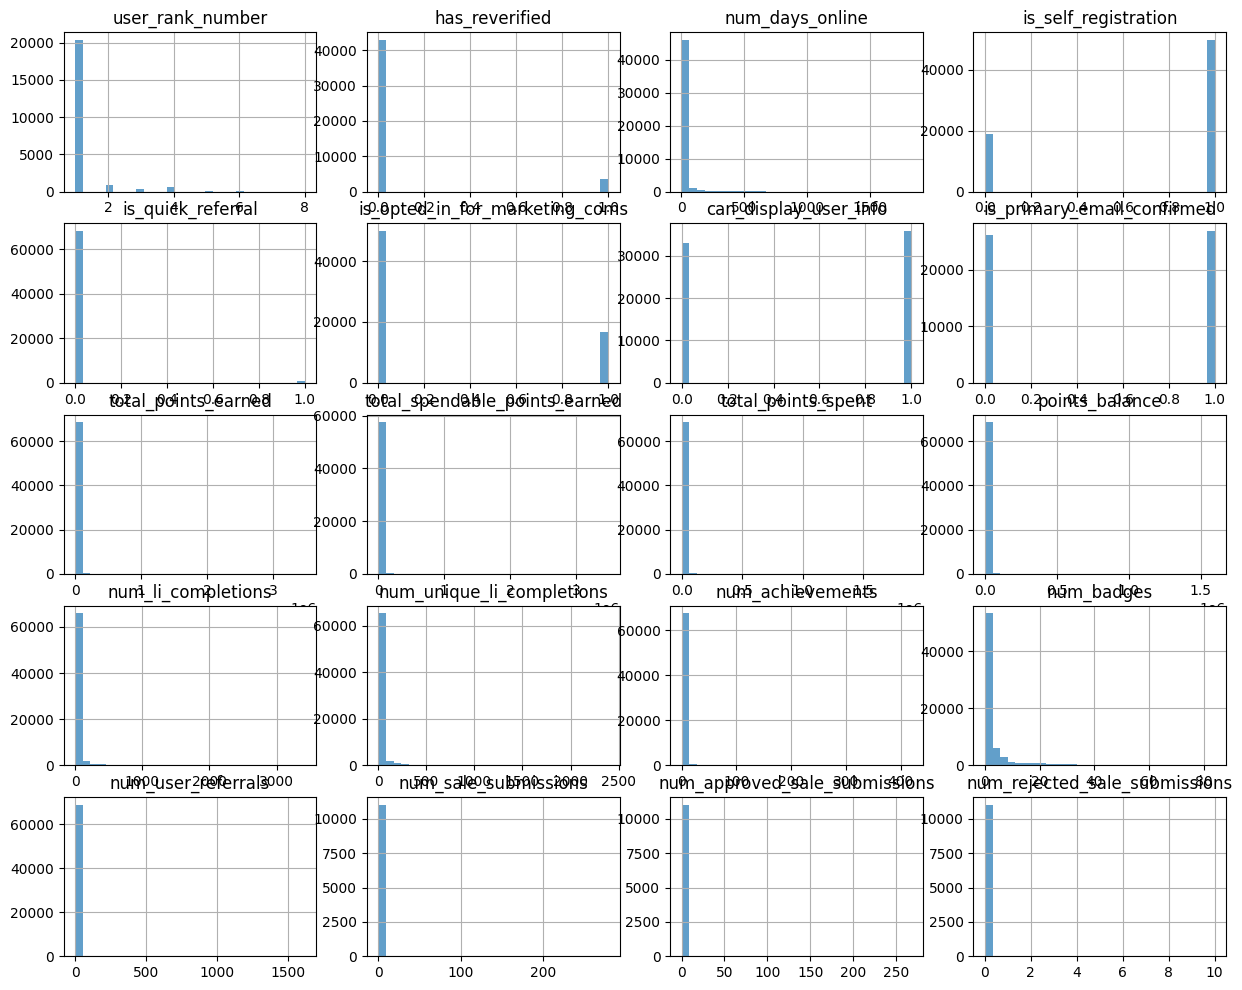

In [40]:
# NUMERICAL COLUMNS ANALYSIS - SIMPLE
print("NUMERICAL COLUMNS ANALYSIS")
print("=" * 30)

# Get numerical columns
num_cols = users_business.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Numerical columns: {len(num_cols)}")

# Basic stats
print("\nBASIC STATISTICS:")
print(users_business[num_cols].describe())

# Create histograms with proper grid size
import matplotlib.pyplot as plt

rows = 5  # Increased to fit 18 columns
cols = 4
plt.figure(figsize=(15, 12))

for i, col in enumerate(num_cols, 1):
    plt.subplot(rows, cols, i)
    users_business[col].hist(bins=30, alpha=0.7)
    plt.title(col)
    
plt.tight_layout()
plt.show()

## **Distribution Patterns:**

### **User Engagement Metrics:**
- **`num_li_completions`**: Majority (50%) have 0 completions - low learning engagement
- **`num_days_online`**: 75% of users have ≤4 days online - high churn rate
- **`points_balance`**: Median 560 points, but huge variance (max 2.3M) - power users vs casual

### **User Behavior:**
- **`is_self_registration`**: 64% self-registered - strong organic growth
- **`is_quick_referral`**: Only 1% used quick referral - referral program underutilized
- **`has_reverified`**: 5% re-verified accounts - low re-engagement

### **Gamification Performance:**
- **`num_achievements`**: 75% have 0 achievements - gamification not effective
- **`num_badges`**: 50% have 0 badges - low badge engagement
- **`user_rank_number`**: 68% at rank 0 - progression system underused

### **Business Metrics:**
- **`total_points_earned`**: Wide range (0 to 7.4M) - extreme user segmentation
- **`num_user_referrals`**: 75% have 0 referrals - viral growth limited
- **`num_connections`**: 75% have 0 connections - social features underutilized

## **Critical Findings:**

1. **Engagement Crisis**: Majority users inactive (0 completions, 0 achievements)
2. **Retention Issue**: Most users spend ≤4 days on platform
3. **Gamification Gap**: Reward systems not driving engagement
4. **Social Deficit**: Low referral and connection activity


## **Categorical Columns**
### PART 1: First 13 


user_id:
  10003: 1 (0.0%)
  4: 1 (0.0%)
  10010: 1 (0.0%)
  10019: 1 (0.0%)
  10007: 1 (0.0%)

account_status:
  Deleted: 23,837 (35.7%)
  Active: 22,882 (34.3%)
  Disabled: 11,633 (17.4%)
  Pending Account Creation: 7,646 (11.5%)
  Merged: 706 (1.1%)

verification_status:
  Verified: 25,771 (38.6%)
  Unverified: 20,685 (31.0%)
  Expired: 20,235 (30.3%)
  Partially Verified: 8 (0.0%)
  Pending: 4 (0.0%)

user_type:
  Retail Sales Associates: 25,437 (38.1%)
  Retail Sales Associate: 7,685 (11.5%)
  Sales Associates: 4,866 (7.3%)
  Dealer/Distributor: 4,327 (6.5%)
  Store Employees: 4,149 (6.2%)

hierarchy_title:
  Motorola Insiders: 26,202 (39.3%)
  North America: 8,310 (12.5%)
  Not Specified: 4,402 (6.6%)
  Non-Marvin: 4,327 (6.5%)
  Consumer & CFNA: 3,757 (5.6%)

retailer:
  T-Mobile: 6,831 (10.2%)
  All Allina Locations: 3,288 (4.9%)
  Cricket: 3,018 (4.5%)
  Prime Communications: 2,638 (4.0%)
  Best Buy US: 2,237 (3.4%)

location_country_code:
  Unknown: 43,715 (65.5%)
  US: 19,1

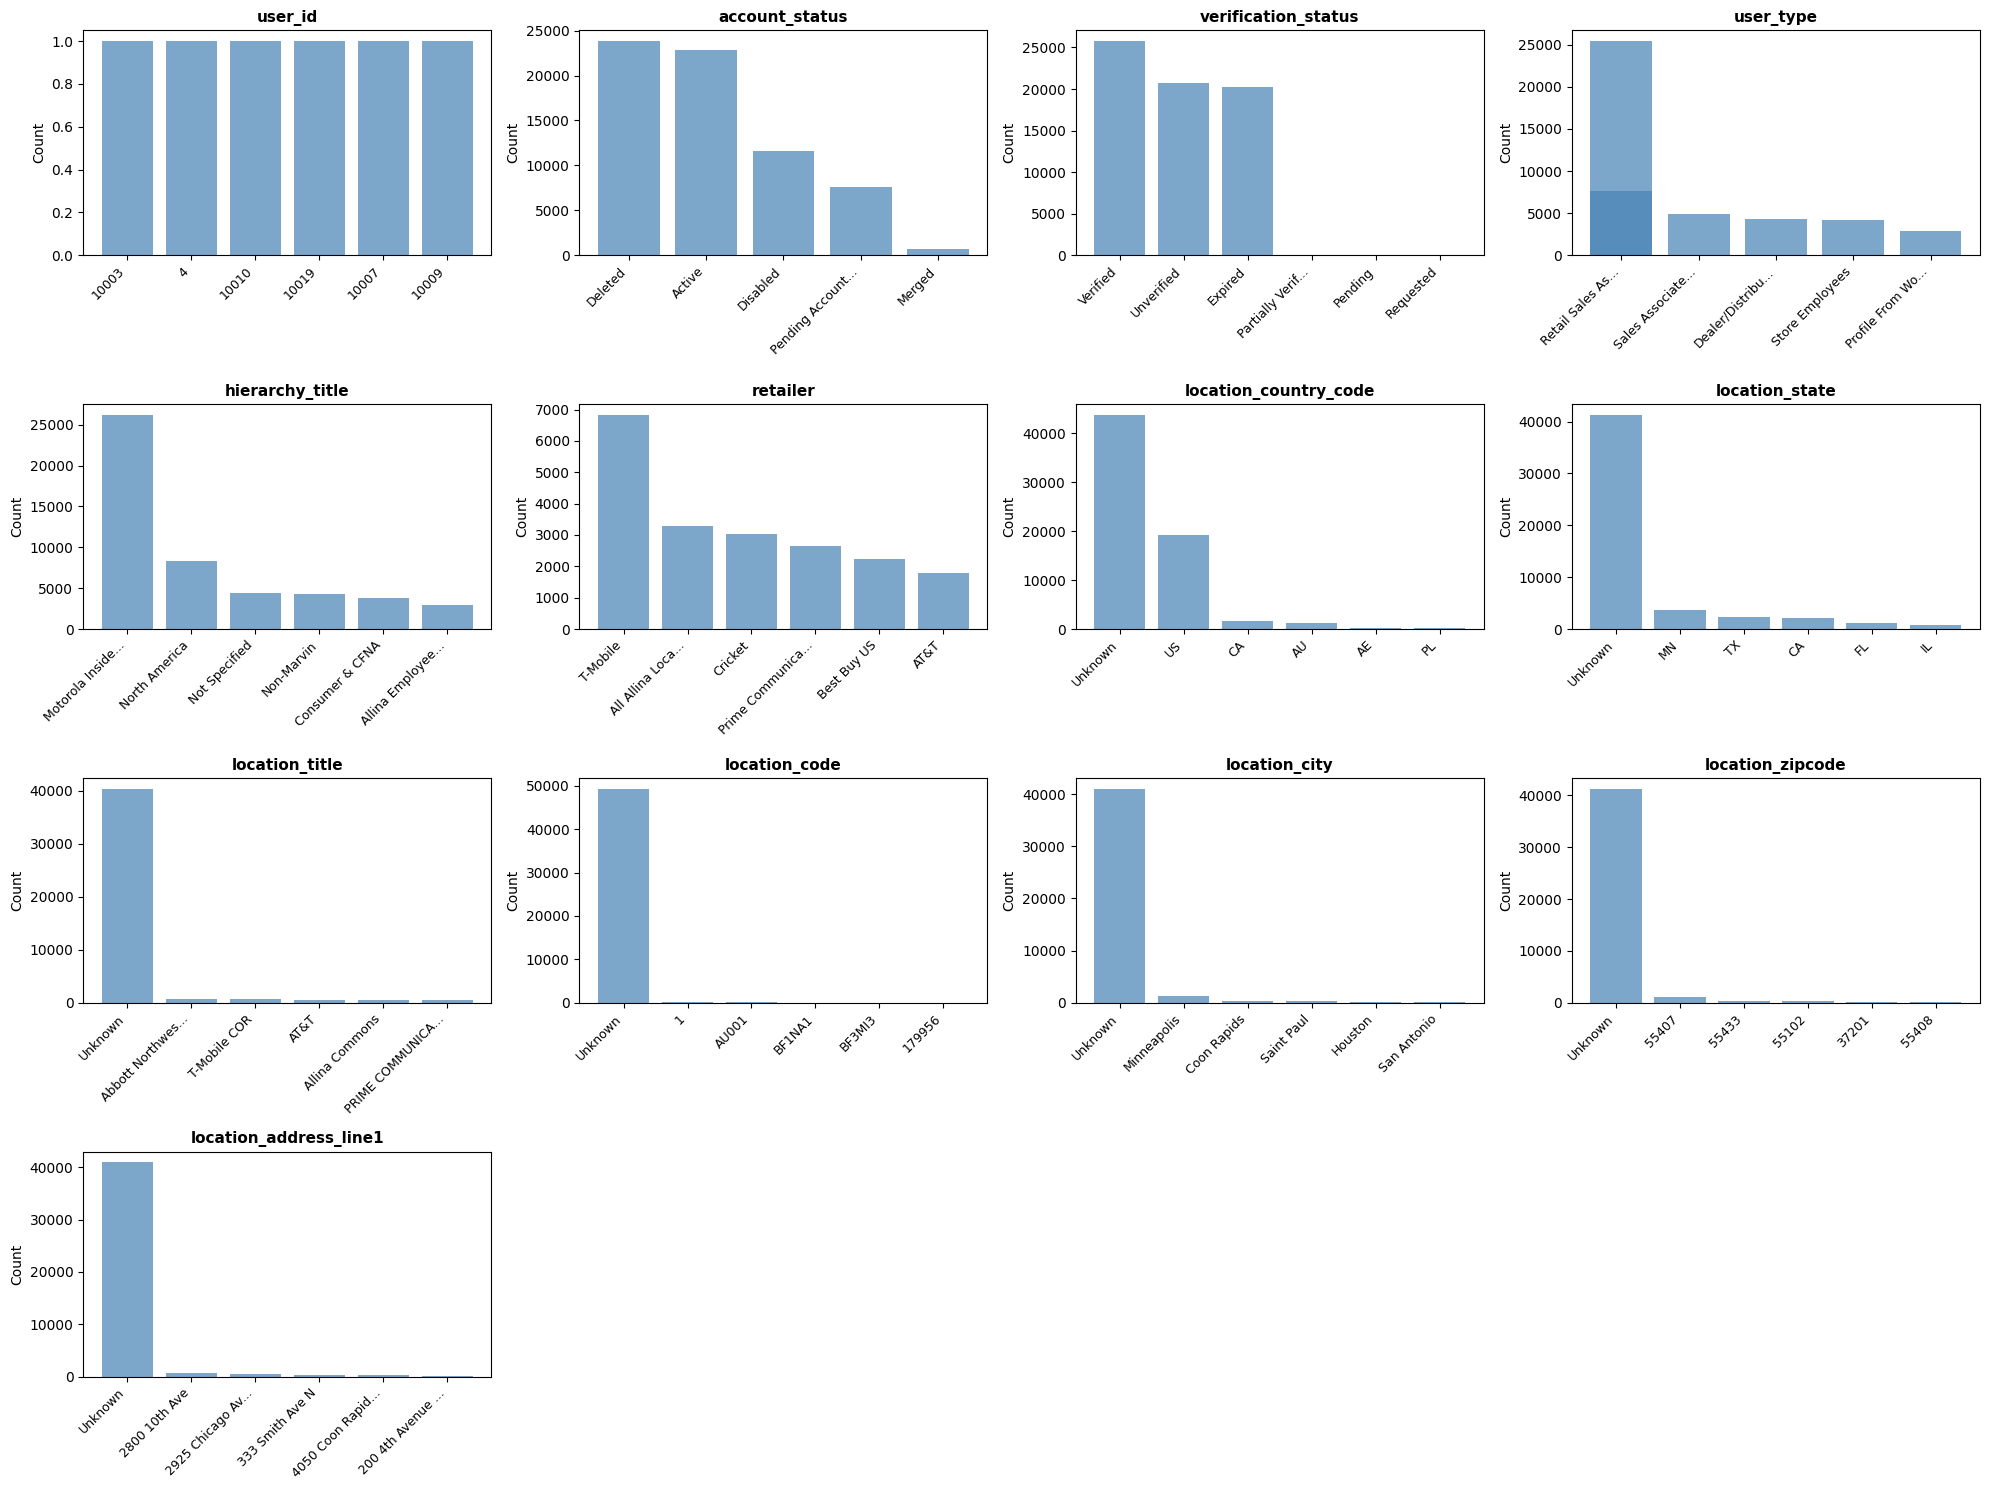

In [ ]:
import matplotlib.pyplot as plt

# Part 1: First 13 categorical columns
cat_cols = users_business.select_dtypes(include=['object']).columns.tolist()
cat_cols_part1 = cat_cols[:13]

# Show top 5 values for each column
for col in cat_cols_part1:
    print(f"\n{col}:")
    top = users_business[col].value_counts().head(5)
    for val, cnt in top.items():
        pct = (cnt / len(users_business)) * 100
        print(f"  {val}: {cnt:,} ({pct:.1f}%)")

# Plot bar charts
plt.figure(figsize=(20, 15))
for i, col in enumerate(cat_cols_part1, 1):
    plt.subplot(4, 4, i)
    top = users_business[col].value_counts().head(6)
    labels = [str(l)[:15] + '...' if len(str(l)) > 15 else str(l) for l in top.index]
    plt.bar(labels, top.values, color='steelblue', alpha=0.7)
    plt.title(col, fontsize=11, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylabel('Count', fontsize=10)

plt.tight_layout()
plt.show()


### User Dataset Summary (Total: ~66.75k)

**Account Status**
- Inactive (54.6%): Deleted (35.7%) + Disabled (17.4%)
- Active: 34.3%
- Pending Creation: 11.5%

**Verification**
- Verified: 38.6%
- Not Verified: 61.3% (Unverified 31.0% + Expired 30.3%)

**User Composition**
- Primarily Retail Sales roles (38.1% "Retail Sales Associates")
- "Motorola Insiders" program dominant (39.3%)

**Top Retailers**
- T-Mobile (10.2%), Allina (4.9%), Cricket (4.5%)

**Location Data**
- Critical data quality issue
- >60% "Unknown" across all location fields
- Primary known locations: US (28.7%), MN/TX/CA states


country_code:
  US: 43,270 (64.9%)
  CA: 4,615 (6.9%)
  Unknown: 4,546 (6.8%)
  MX: 3,033 (4.5%)
  IN: 1,961 (2.9%)

country_name:
  United States: 47,625 (71.4%)
  Canada: 4,621 (6.9%)
  Mexico: 3,033 (4.5%)
  India: 1,961 (2.9%)
  United Kingdom: 1,558 (2.3%)

user_rank_title:
  No Rank: 49,561 (74.3%)
  hellobeginner: 9,788 (14.7%)
  Newbie: 3,516 (5.3%)
  Crescendo Climber: 597 (0.9%)
  Rapid Rookie: 561 (0.8%)

verification_expired_ts:
  Never Verified: 46,260 (69.4%)
  2023-07-20 00:00:12: 396 (0.6%)
  2023-07-20 00:00:11: 390 (0.6%)
  2023-07-20 00:00:09: 377 (0.6%)
  2025-01-07 01:00:03: 364 (0.5%)

first_verification_method:
  Not Verified: 19,840 (29.7%)
  Referral Code: 15,743 (23.6%)
  Admin: 10,561 (15.8%)
  Company Email: 9,563 (14.3%)
  Code Set: 6,043 (9.1%)

referred_by_referral_code:
  No Referral: 44,122 (66.1%)
  CR3BW: 385 (0.6%)
  CT6WK: 357 (0.5%)
  PS3CR: 303 (0.5%)
  PX3DQ: 177 (0.3%)

referred_by_user_id:
  No Referrer: 44,122 (66.1%)
  55636: 375 (0.6%)
  12

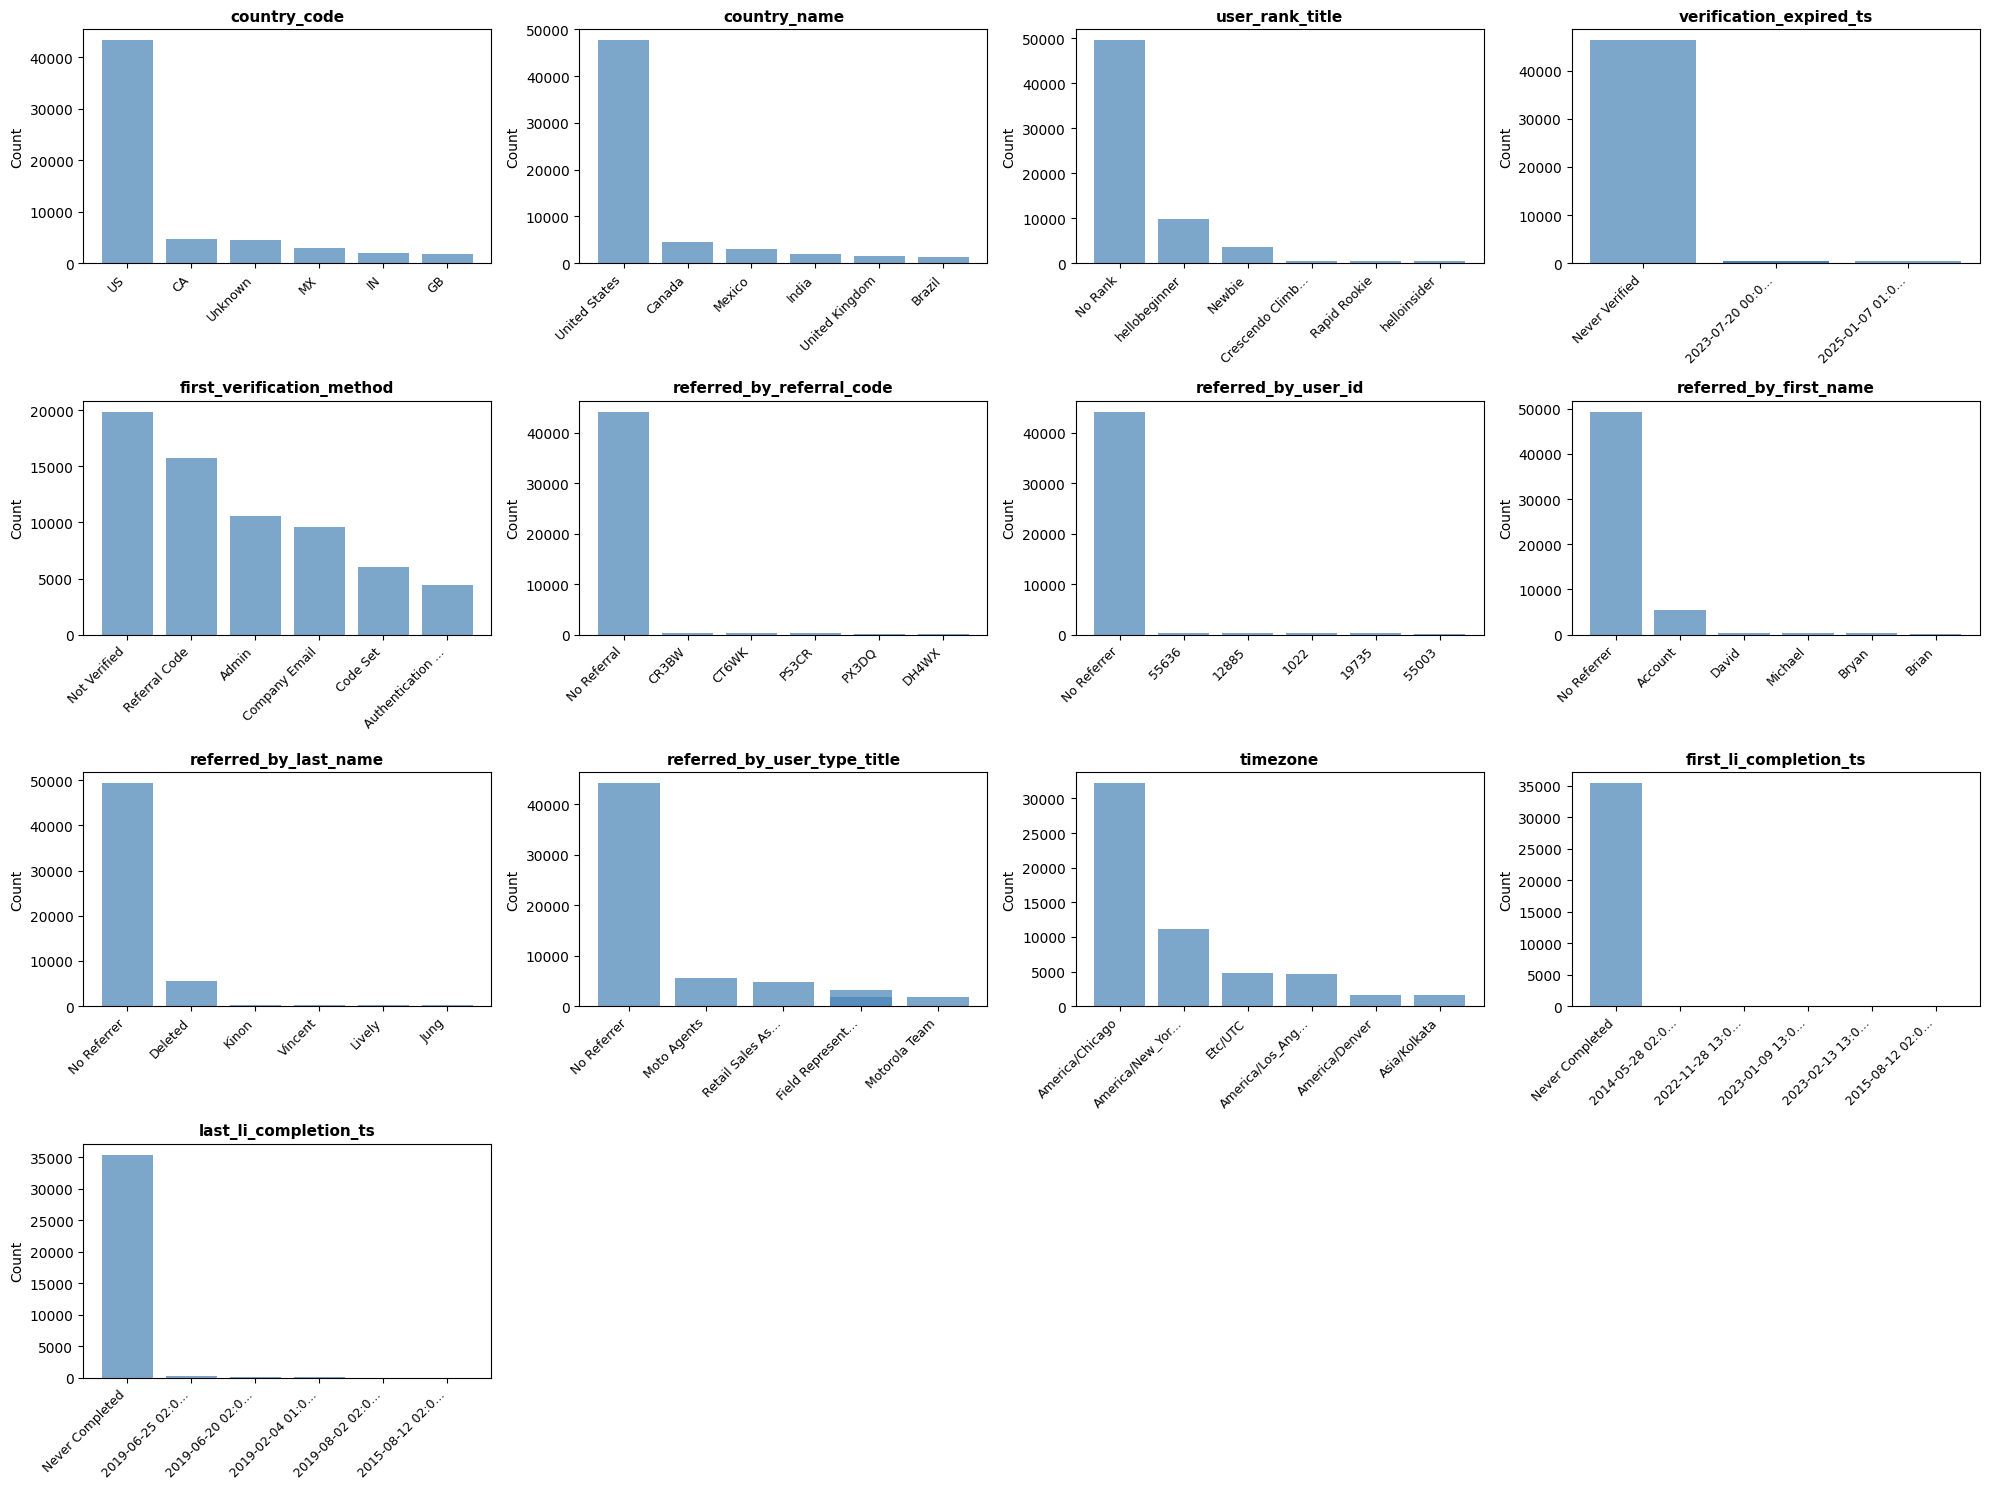

In [ ]:
# Part 2: Remaining categorical columns 
cat_cols_part2 = cat_cols[13:]  # Taking the remaining columns after the first 13

# Show top 5 values for each remaining column
for col in cat_cols_part2:
    print(f"\n{col}:")
    top = users_business[col].value_counts().head(5)
    for val, cnt in top.items():
        pct = (cnt / len(users_business)) * 100
        print(f"  {val}: {cnt:,} ({pct:.1f}%)")

# Plot bar charts for remaining columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(cat_cols_part2, 1):
    plt.subplot(4, 4, i)
    top = users_business[col].value_counts().head(6)
    labels = [str(l)[:15] + '...' if len(str(l)) > 15 else str(l) for l in top.index]
    plt.bar(labels, top.values, color='steelblue', alpha=0.7)
    plt.title(col, fontsize=11, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.ylabel('Count', fontsize=10)

plt.tight_layout()
plt.show()


**Geographic Distribution**
- **US Dominance**: 71.4% of users from United States
- **Timezone**: 48.2% in America/Chicago (Central Time)
- **Top Countries**: US (64.9%), Canada (6.9%), Mexico (4.5%)

**User Ranking & Status**
- **No Rank**: 74.3% of users have no rank
- **Beginner Ranks**: hellobeginner (14.7%), Newbie (5.3%)

**Verification Methods**
- **Not Verified**: 29.7% never verified
- **Primary Methods**: Referral Code (23.6%), Admin (15.8%), Company Email (14.3%)

**Referral System**
- **No Referrals**: 66.1% of users not referred by anyone
- **Top Referrers**: Moto Agents (8.5%), Retail Sales Associates (7.0%)

**Learning Activity**
- **Never Completed**: 53.0% never completed learning modules
- **Low Engagement**: Very few completion timestamps show minimal ongoing activity

DATETIME COLUMNS ANALYSIS - ALL 9 COLUMNS


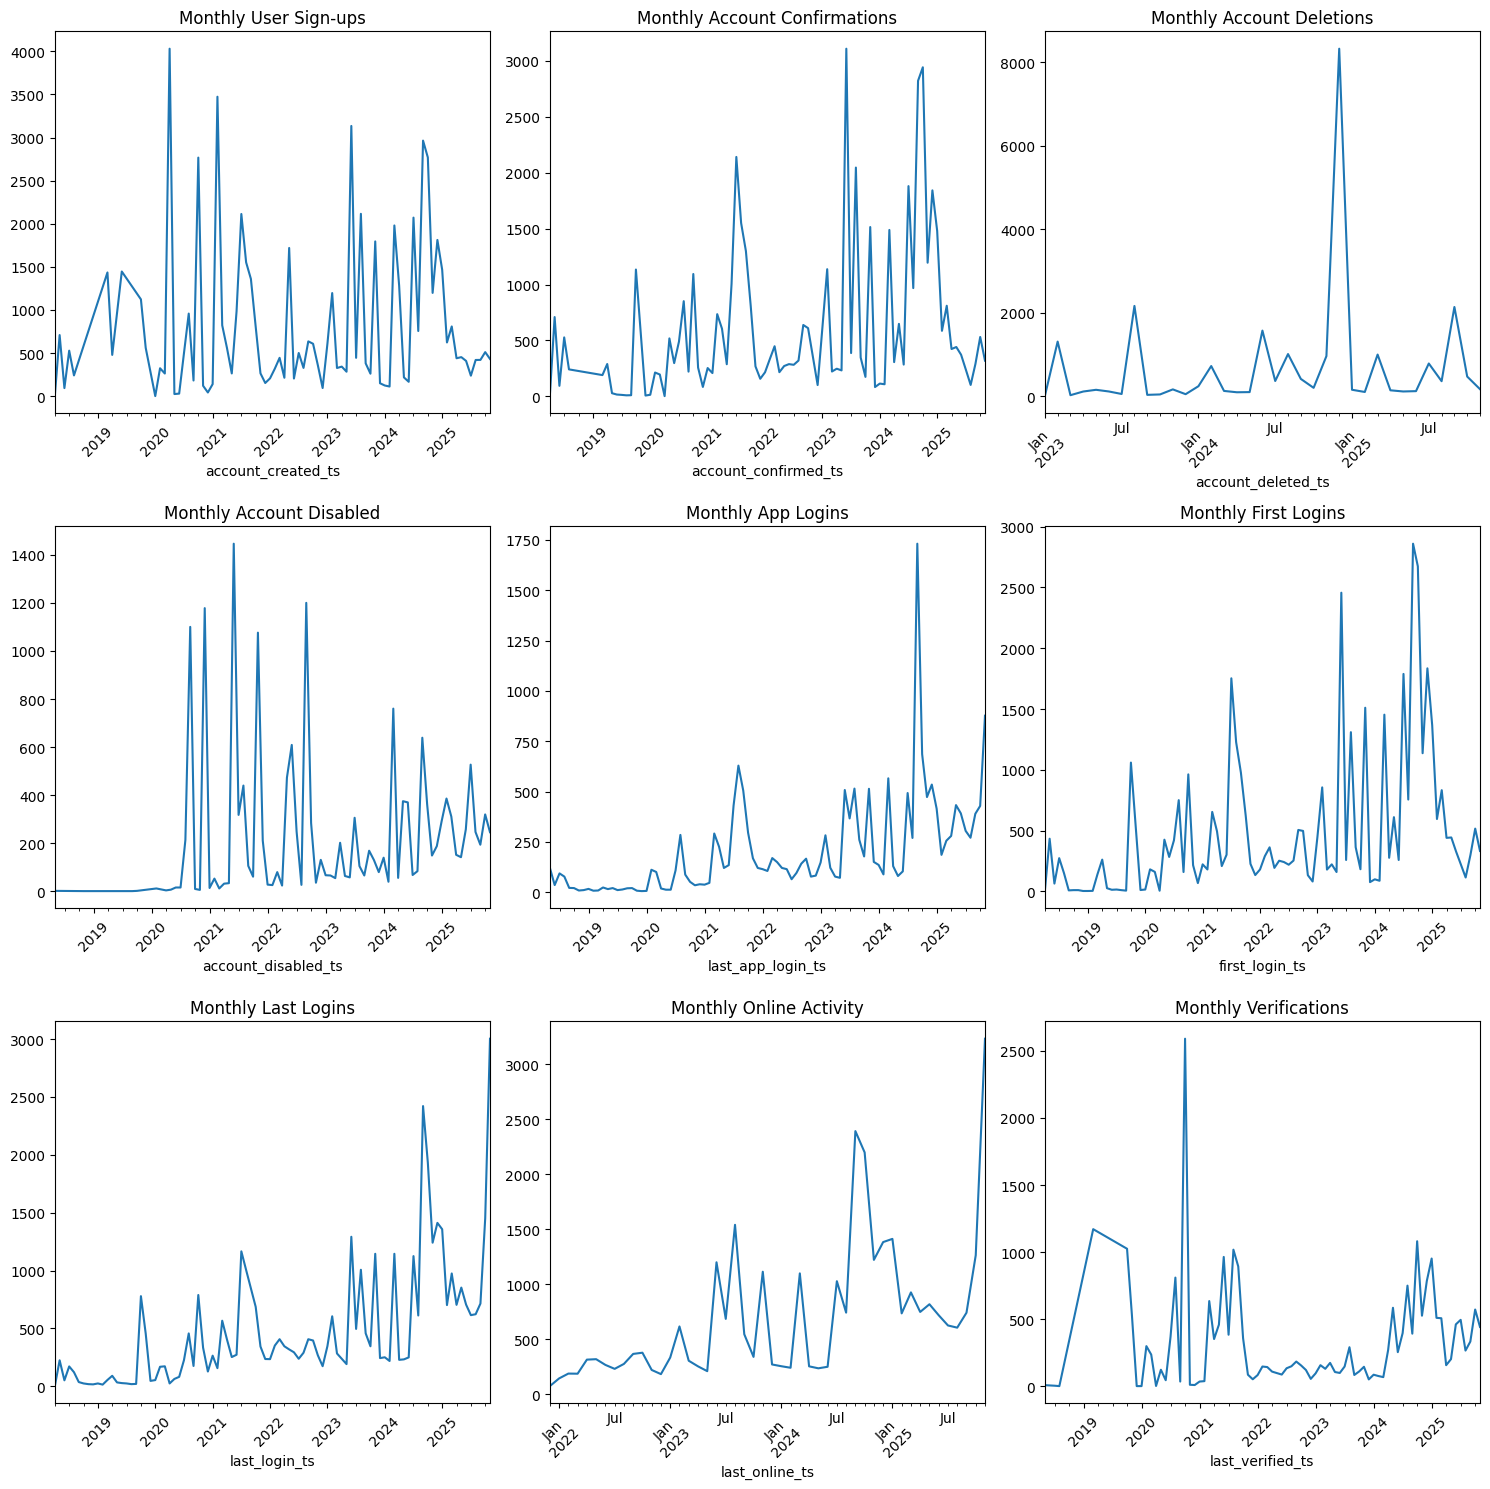


COMPLETION RATES FOR ALL 9 DATETIME COLUMNS:
Total users: 66,704
account_created_ts  : 66,704 users (100.0%)
account_confirmed_ts: 51,781 users ( 77.6%)
account_deleted_ts  : 23,841 users ( 35.7%)
account_disabled_ts : 17,216 users ( 25.8%)
last_app_login_ts   : 18,585 users ( 27.9%)
first_login_ts      : 44,302 users ( 66.4%)
last_login_ts       : 44,302 users ( 66.4%)
last_online_ts      : 33,626 users ( 50.4%)
last_verified_ts    : 25,771 users ( 38.6%)


In [ ]:
# DATETIME COLUMNS ANALYSIS - ALL 9 COLUMNS
print("DATETIME COLUMNS ANALYSIS - ALL 9 COLUMNS")
print("=" * 40)

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# All 9 datetime columns
datetime_plots = [
    ('account_created_ts', 'User Sign-ups'),
    ('account_confirmed_ts', 'Account Confirmations'), 
    ('account_deleted_ts', 'Account Deletions'),
    ('account_disabled_ts', 'Account Disabled'),
    ('last_app_login_ts', 'App Logins'),
    ('first_login_ts', 'First Logins'),
    ('last_login_ts', 'Last Logins'),
    ('last_online_ts', 'Online Activity'),
    ('last_verified_ts', 'Verifications')
]

for i, (col, title) in enumerate(datetime_plots, 1):
    plt.subplot(3, 3, i)
    users_business[col].dt.to_period('M').value_counts().sort_index().plot()
    plt.title(f'Monthly {title}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Show completion rates for ALL 9
print("\nCOMPLETION RATES FOR ALL 9 DATETIME COLUMNS:")
total_users = len(users_business)
print(f"Total users: {total_users:,}")

for col, title in datetime_plots:
    completed = users_business[col].notna().sum()
    rate = (completed / total_users) * 100
    print(f"{col:20}: {completed:6,} users ({rate:5.1f}%)")

# DATETIME COLUMNS ANALYSIS - KEY INSIGHTS

## **User Growth & Activity Patterns**

### **Account Lifecycle:**
- **100% Complete Data**: All 66,704 users have account creation dates
- **77.6% Confirmation Rate**: Majority complete account setup
- **35.7% Deletion Rate**: Significant user churn, especially mid-2023 spike
- **25.8% Disablement**: Moderate account suspension activity

### **Engagement Metrics:**
- **66.4% Login Activity**: 2/3 of users have logged in at least once
- **50.4% Online Presence**: Half of users show recent platform activity
- **27.9% App Usage**: Growing mobile engagement trend
- **38.6% Verified**: Low verification completion rate

## **Critical Business Findings**

### **Growth Patterns:**
- **Volatile Acquisition**: Spiky sign-ups suggest campaign-driven growth
- **Mobile Shift**: App usage shows clear upward trend from 2022
- **Retention Challenge**: High deletion rates indicate user retention issues

### **Engagement Gaps:**
- **Verification Bottleneck**: Only 38.6% complete verification
- **App Adoption Opportunity**: 72% of users not using mobile app
- **Activity Drop-off**: 33% of users never logged in after sign-up

## BIVARIATE ANALYSIS

#### **1. Engagement vs User Status**

COMPREHENSIVE BIVARIATE ANALYSIS
Numerical columns: 18
Categorical columns: 27

1. NUMERICAL vs NUMERICAL CORRELATIONS


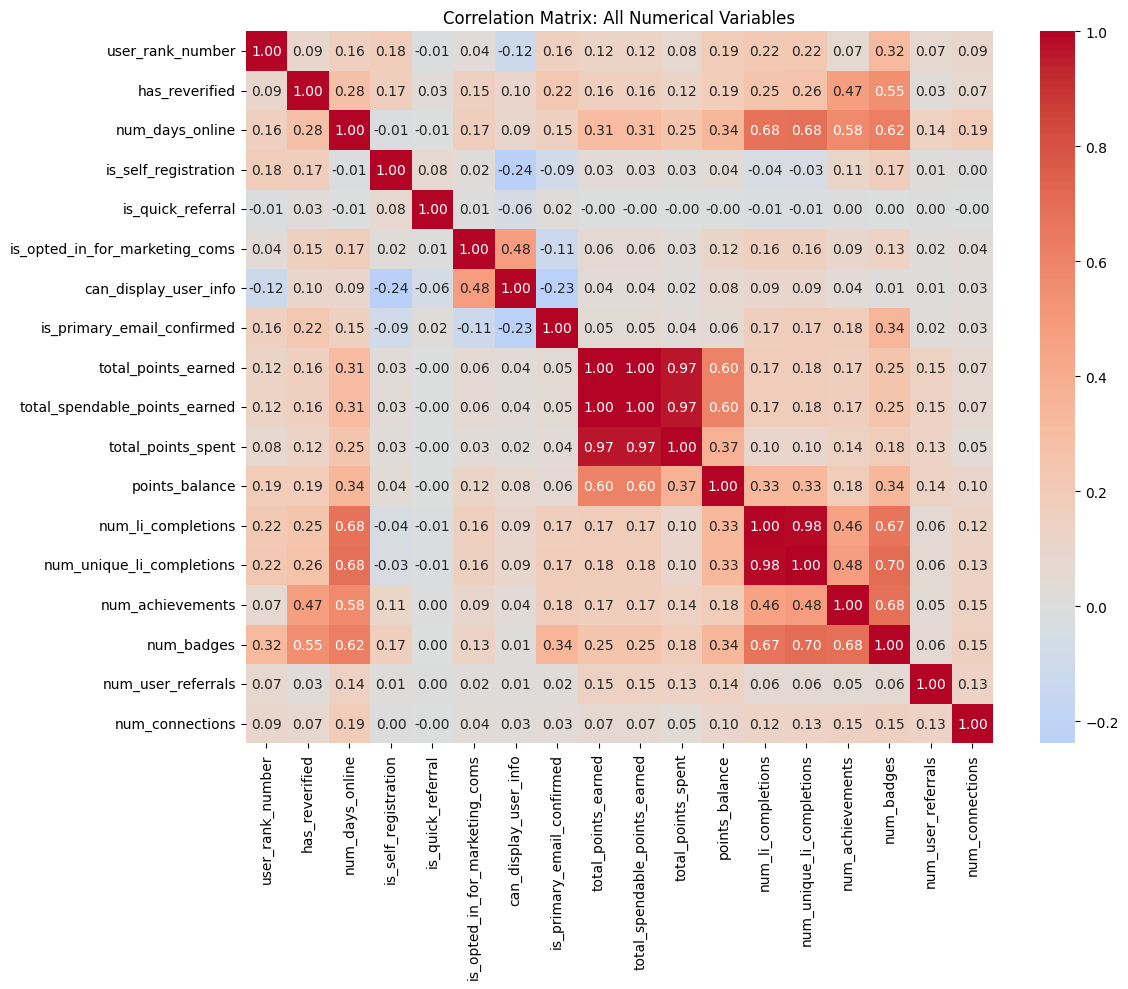

TOP CORRELATIONS:
  num_unique_li_completions vs num_li_completions: 0.984
  num_li_completions vs num_unique_li_completions: 0.984
  total_points_spent vs total_points_earned: 0.966
  total_points_earned vs total_points_spent: 0.966
  total_points_spent vs total_spendable_points_earned: 0.966
  total_spendable_points_earned vs total_points_spent: 0.966
  num_badges vs num_unique_li_completions: 0.699
  num_unique_li_completions vs num_badges: 0.699
  num_unique_li_completions vs num_days_online: 0.683
  num_days_online vs num_unique_li_completions: 0.683


In [ ]:
# COMPREHENSIVE BIVARIATE ANALYSIS - ALL COLUMNS
print("COMPREHENSIVE BIVARIATE ANALYSIS")
print("=" * 45)

# Get all column types
num_cols = users_business.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = users_business.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical columns: {len(num_cols)}")
print(f"Categorical columns: {len(cat_cols)}")

# 1. NUMERICAL vs NUMERICAL - Correlation Matrix
print("\n1. NUMERICAL vs NUMERICAL CORRELATIONS")
plt.figure(figsize=(12, 10))
corr_matrix = users_business[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: All Numerical Variables')
plt.tight_layout()
plt.show()

# Show top correlations
print("TOP CORRELATIONS:")
corr_pairs = corr_matrix.unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 0.99]  # Remove self-correlations
for i, (pair, value) in enumerate(corr_pairs.head(10).items()):
    print(f"  {pair[0]} vs {pair[1]}: {value:.3f}")


2. CATEGORICAL vs NUMERICAL ANALYSIS


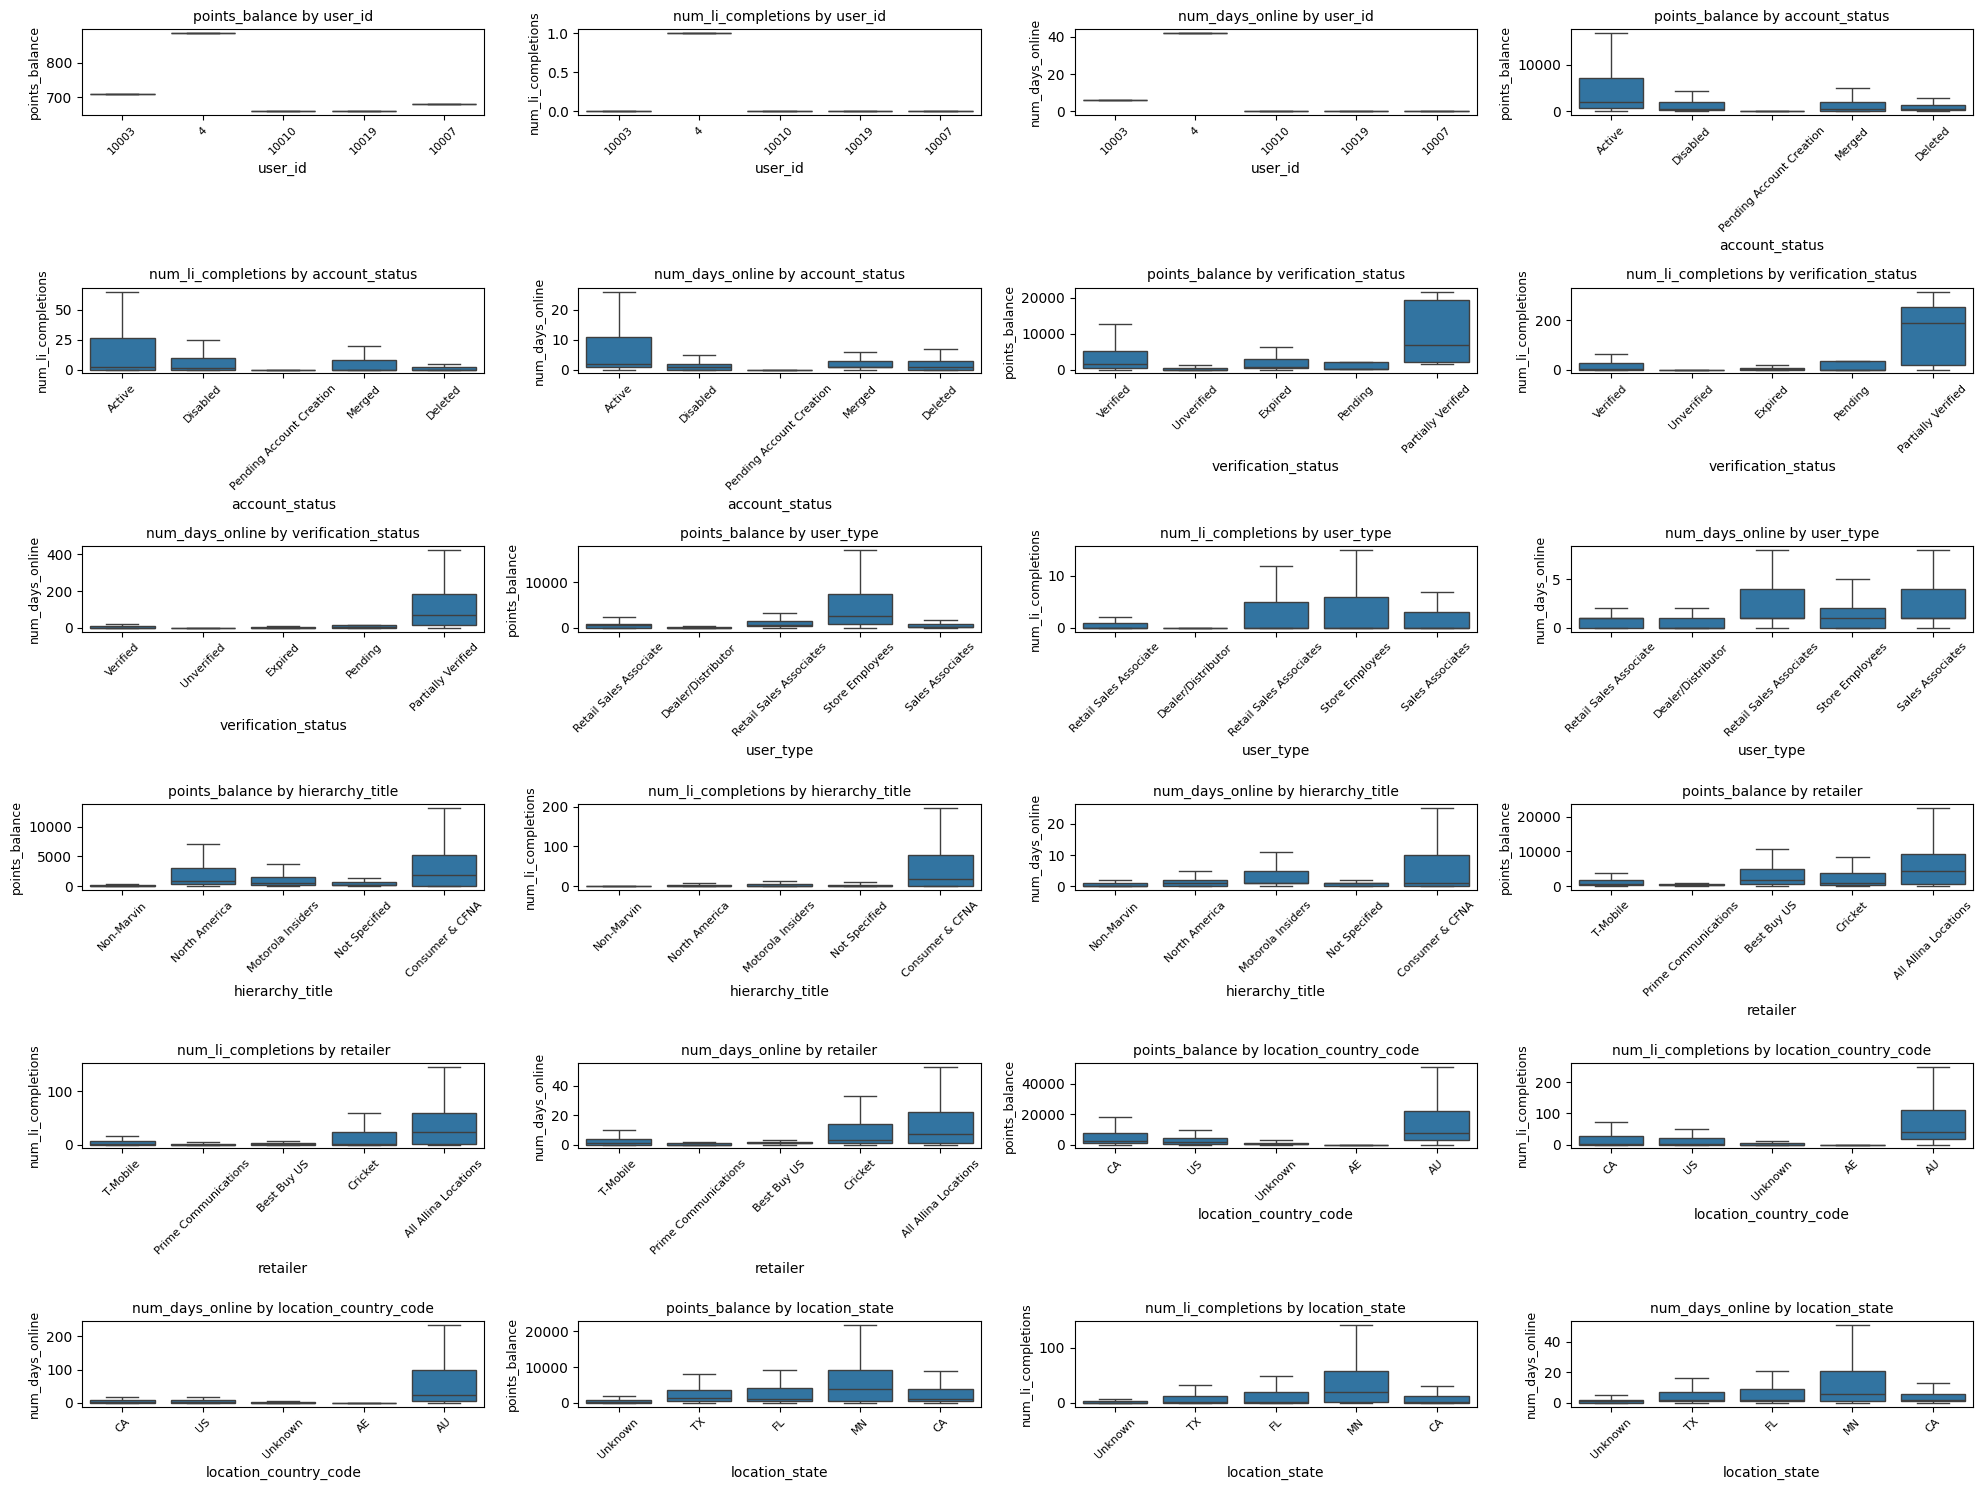

In [ ]:
# 2. CATEGORICAL vs NUMERICAL - ANOVA/T-tests
print("\n2. CATEGORICAL vs NUMERICAL ANALYSIS")

# Analyze top 8 categorical variables against key numerical metrics
key_numerical = ['points_balance', 'num_li_completions', 'num_days_online']
top_categorical = cat_cols[:8]  # First 8 categorical columns

plt.figure(figsize=(20, 15))
plot_num = 1

for cat_col in top_categorical:
    for num_col in key_numerical:
        if plot_num <= 24:  # Limit to 24 plots
            plt.subplot(6, 4, plot_num)
            
            # Get top 5 categories for clean visualization
            top_cats = users_business[cat_col].value_counts().head(5).index
            filtered_data = users_business[users_business[cat_col].isin(top_cats)]
            
            # Create box plot without outliers for clarity
            sns.boxplot(data=filtered_data, x=cat_col, y=num_col, showfliers=False)
            plt.title(f'{num_col} by {cat_col}', fontsize=10)
            plt.xticks(rotation=45, fontsize=8)
            plt.ylabel(num_col, fontsize=9)
            
            plot_num += 1

plt.tight_layout()
plt.show()